###This notebook:
+ ktrain
+ hugging face transformers
+ roberta-base
+ LR == 5e-5
+ LR policy: autofit (triangle)
+ no pre-processing of texts

###Check requirements/Imports

In [ ]:
! python --version

Python 3.7.10


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import os

import numpy as np
import pandas as pd

from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
!pip3 install ktrain

In [ ]:
pip install contractions

In [ ]:
pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Data part

###Load training data

In [ ]:
# Load train data
train_path = '/content/drive/MyDrive/TeamLab/data/corrected_isear-train.csv'

df_train = pd.read_csv(train_path, names=['emotion', 'text', 'NaN'])                          

In [ ]:
df_train.head()

,emotion,text,NaN
0,joy,When I understood that I was admitted to the U...,NaN
1,fear,I broke a window of a neighbouring house and I...,NaN
2,joy,Got a big fish in fishing.,NaN
3,fear,"Whenever I am alone in a dark room, walk alone...",NaN
4,shame,I bought a possible answer to a homework probl...,NaN


In [ ]:
classes = df_train.emotion.unique()
classes

In [ ]:
# Check if dataset is balanced

for emo in classes:
    n_instances = (df_train.emotion == emo).sum()
    print(emo, "class has", n_instances, "instances")

# => Balanced

joy class has 779 instances
fear class has 758 instances
shame class has 762 instances
disgust class has 762 instances
guilt class has 770 instances
anger class has 758 instances
sadness class has 768 instances


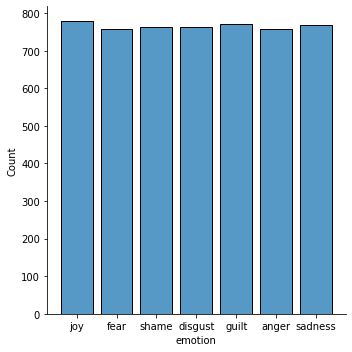

In [ ]:
import seaborn as sns

sns.displot(df_train, x="emotion", shrink=.8)

###Load validation data

In [ ]:
# Load validation data
val_path = '/content/drive/MyDrive/TeamLab/data/corrected_isear-val.csv'

df_val = pd.read_csv(val_path, names=['emotion', 'text', 'NaN'])

df_val.head()

,emotion,text,NaN
0,joy,"On holiday, seeing the lanscape in Gerona.",NaN
1,guilt,When one of my parents insinuates something ab...,NaN
2,sadness,When I am alone and listen to a song which I l...,NaN
3,joy,I'd just got the top mark in an exam.,NaN
4,shame,"I remember that once, a friend did not co-oper...",NaN


###Load test data

In [ ]:
# Load test data
test_path = '/content/drive/MyDrive/TeamLab/data/corrected_isear-test.csv'

df_test = pd.read_csv(test_path, names=['emotion', 'text', 'NaN'])

df_test.head()

,emotion,text,NaN
0,anger,Deliberately provoked by someone close. Angere...,NaN
1,shame,In my 20s - and was going out to dinner to cel...,NaN
2,guilt,When I noticed that my little sister was sulki...,NaN
3,disgust,I got disgusted with a man who was beating a w...,NaN
4,joy,When I passed the driving test (on the second ...,NaN


In [ ]:
x_train = df_train['text'].to_numpy()
y_train = df_train['emotion'].to_numpy()

x_val = df_val['text'].to_numpy()
y_val = df_val['emotion'].to_numpy()

x_test = df_test['text'].to_numpy()
y_test = df_test['emotion'].to_numpy()

print(x_train[0])
print(y_train[0])

When I understood that I was admitted to the University.
joy


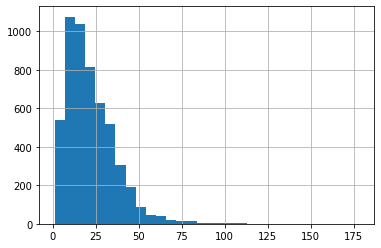

In [ ]:
# get length of all the texts in the train set
seq_len = [len(i.split()) for i in x_train]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
from statistics import mean

print(max(seq_len))
print(mean(seq_len))

178
21.803994773193953


In [ ]:
seq_len = []

idx = 0
for text in x_train:
    if len(text.split()) > 75:
        print(idx, text)
    seq_len.append(len(text.split()))
    idx += 1

# some sentences are v long (:

##Model

###Set up

In [ ]:
import ktrain
from ktrain import text

categories = ['joy', 'fear', 'shame', 'disgust', 'guilt', 'anger', 'sadness']

MODEL_NAME = 'roberta-base'

# Transormer is a wrapper to the Hugging Face transformers library for text classification.
# maxlen=??
t = text.Transformer(MODEL_NAME, maxlen=150, class_names=categories)

# input data
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)


preprocessing train...
language: en
train sequence lengths:
	mean : 22
	95percentile : 48
	99percentile : 70


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 22
	95percentile : 47
	99percentile : 76


###Estimate learning rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
334/334 [==============================] - 314s 923ms/step - loss: 1.9517 - accuracy: 0.1430
Epoch 2/5
334/334 [==============================] - 308s 923ms/step - loss: 1.3677 - accuracy: 0.5149
Epoch 3/5
334/334 [==============================] - 308s 923ms/step - loss: 1.8393 - accuracy: 0.2479
Epoch 4/5
334/334 [==============================] - 118s 351ms/step - loss: 10.5410 - accuracy: 0.1562


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


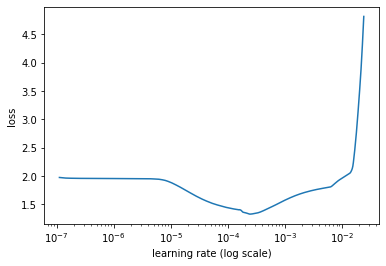

In [ ]:
# Estimate good learning rate

# set max_epochs or this will take hours to run (default epochs == 1024!!)
learner.lr_find(max_epochs=5)
learner.lr_plot()

###Train

In [ ]:
# the maximal learning rate associated with a still falling loss is a good choice for training
best_lr = 5e-5

In [ ]:
# Train
# Parameters: LR, epochs

# Learning policies: 
# triangular LR -> learner.autofit(0.0007, 8) (implicit ReduceLROnPlateau and EarlyStopping)
# 1cycle -> learner.fit_onecycle(best_lr, 5)

#learner.autofit(best_lr, 10, early_stopping=True)

learner.autofit(lr=best_lr, checkpoint_folder='/my_models', verbose=1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
335/335 [==============================] - 354s 1s/step - loss: 1.2817 - accuracy: 0.5208 - val_loss: 0.8413 - val_accuracy: 0.7056
Epoch 2/1024
335/335 [==============================] - 337s 1s/step - loss: 0.7542 - accuracy: 0.7407 - val_loss: 0.8328 - val_accuracy: 0.7160
Epoch 3/1024
335/335 [==============================] - 336s 1000ms/step - loss: 0.5981 - accuracy: 0.7976 - val_loss: 0.8796 - val_accuracy: 0.7221
Epoch 4/1024
335/335 [==============================] - 337s 1s/step - loss: 0.4824 - accuracy: 0.8421 - val_loss: 0.9444 - val_accuracy: 0.7047

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 5/1024
335/335 [==============================] - 337s 1s/step - loss: 0.3180 - accuracy: 0.8940 - val_loss: 0.9949 - val_accuracy: 

###Evaluate/Inspect model

In [ ]:
# Set weights to those of the best epoch
learner.model.load_weights('/my_models/weights-03.hdf5')

In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

       anger       0.60      0.76      0.67       160
     disgust       0.73      0.65      0.69       159
        fear       0.88      0.74      0.80       171
       guilt       0.64      0.68      0.66       165
         joy       0.88      0.90      0.89       151
     sadness       0.78      0.76      0.77       175
       shame       0.61      0.58      0.60       167

    accuracy                           0.72      1148
   macro avg       0.73      0.72      0.72      1148
weighted avg       0.73      0.72      0.72      1148



array([[121,  10,   3,  12,   0,   8,   6],
       [ 31, 103,   1,   4,   4,   6,  10],
       [  7,  11, 126,  11,   3,   6,   7],
       [ 12,   2,   5, 113,   3,   5,  25],
       [  1,   1,   2,   2, 136,   3,   6],
       [ 13,   5,   2,   7,   7, 133,   8],
       [ 17,   9,   5,  27,   2,  10,  97]])

In [ ]:
# the ones that we got most wrong
learner.view_top_losses(n=10, preproc=t)

----------
id:901 | loss:6.59 | true:guilt | pred:fear)

----------
id:26 | loss:6.21 | true:sadness | pred:joy)

----------
id:574 | loss:6.21 | true:fear | pred:guilt)

----------
id:456 | loss:6.13 | true:disgust | pred:joy)

----------
id:217 | loss:6.08 | true:sadness | pred:joy)

----------
id:893 | loss:6.07 | true:fear | pred:disgust)

----------
id:581 | loss:5.99 | true:disgust | pred:guilt)

----------
id:791 | loss:5.93 | true:fear | pred:joy)

----------
id:707 | loss:5.79 | true:fear | pred:guilt)

----------
id:686 | loss:5.75 | true:anger | pred:sadness)



In [ ]:
# print out instance to see why...
print(x_test[901])
print(x_test[26])
print(x_test[574])
print(x_test[456])
print(x_test[217])

print(x_test[893])
print(x_test[581])
print(x_test[791])
print(x_test[707])
print(x_test[686])

I tried my level best to care for my client, I took an appointment with a doctor and before meeting the doctor he expired - a poor small boy from Uttar Pradesh.
When I saw a drunk man urinate upon himsellf and he seemed to be thoroughly content with it.
Hear my name on the list attending the English lectures.
When I was 13 years old I wrote passionate love letters to my boyfriend and I later found out that his sister had read them.
Noisy people in the library.
After a weekend at a seminar I saw my husband again. I hurried home hoping he would be there. We embraced - I enjoyed feeling his body.
I got back too late after a Sunday going out without having called up home to tell where I was. my mother hadn't slept the whole night.
During my holidays I had a boyfriend who turned away from me outwardly. Therefore I danced with another man and raised certain hopes in him. After a while I had to explain to him the circumstances
When I saw a large spider crawling up the wall.
When I was 8 years

###Make predictions on new data

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
test_sent = ('Even though it is raining, it is a nice day and I do not feel sad')

In [ ]:
predictor.predict(test_sent)

'sadness'

In [ ]:
# Ask for explanation
predictor.explain(test_sent)

nice and not did weigh the probability of 'sadness' down but not enough - pred was still sadness and the P is quite high

In [ ]:
more_sents = ['Playing with a very cute doggo', 
              'Feeling lonely', 
              'I rode at the back of a scooter driven by a stranger on the motorway in Vietnam, not knowing where we were going', 
              'I told my mum a lie and it caused her being very disappointed afterwards', 
              'I shat myself at school', 
              'when I see dirty houses full of useless crap',
              'seeing racist and homophobic comments infuriates me']

In [ ]:
predictor.predict(more_sents)

['joy', 'sadness', 'fear', 'shame', 'shame', 'disgust', 'anger']

In [ ]:
# Ask for explanation
predictor.explain(more_sents[0])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[0])

array([0.01396589, 0.06810563, 0.03160732, 0.03551585, 0.64810085,
       0.00687141, 0.19583301], dtype=float32)

it did not recognise that doggo mean the same as dog? or else why would 'dog' not point to joy? maybe mentioned in dataset together with negative emotions

In [ ]:
# Ask for explanation
predictor.explain(more_sents[1])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[1])

array([0.00456841, 0.00218561, 0.0192802 , 0.01330742, 0.00541362,
       0.9516204 , 0.00362441], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[2])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[2])

array([0.00184642, 0.00177678, 0.9870144 , 0.00113528, 0.00237588,
       0.00232193, 0.00352931], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[3])

intended label was guilt, but shame and guilt seem to be very hard to distinguish. people seem to have very confused definitions about these 2 emotions. P almost 50/50

shame in oneself == guilt?

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[3])

array([0.00411433, 0.00649587, 0.00504776, 0.46587935, 0.00170808,
       0.01021047, 0.50654405], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[4])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[4])

array([0.00753745, 0.0163781 , 0.00659583, 0.1397186 , 0.00161995,
       0.00429528, 0.8238548 ], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[5])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[5])

array([0.23030712, 0.73263866, 0.00439455, 0.00391168, 0.00242952,
       0.02104496, 0.00527347], dtype=float32)

dirty must have had a lot of weight, useless had the opposite effect (more often used by people to express sadness e.g. I feel useless?)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[6])

In [ ]:
t.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [ ]:
predictor.predict_proba(more_sents[6])

array([0.7886594 , 0.16042686, 0.00417407, 0.00444707, 0.00149283,
       0.03122769, 0.00957211], dtype=float32)

racist conveys anger but not homophobic?

###Save + Reload

In [ ]:
predictor.save('/my_models/EC_RoBERTa_nonorm')

In [ ]:
# Reload to check that model has been saved correctly
reloaded_predictor = ktrain.load_predictor('/my_models/EC_RoBERTa_nonorm')

In [ ]:
reloaded_predictor.predict(test_sent)

'sadness'

In [ ]:
# Do reloaded_predictor and original predictor give the same numbers?
reloaded_predictor.predict_proba(test_sent)

array([0.00692911, 0.00266035, 0.01550935, 0.027602  , 0.18014744,
       0.76231027, 0.00484146], dtype=float32)

In [ ]:
predictor.predict_proba(test_sent)

array([0.00692911, 0.00266035, 0.01550935, 0.027602  , 0.18014744,
       0.76231027, 0.00484146], dtype=float32)

In [ ]:
reloaded_predictor.get_classes()

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

**!!!before running next cell:**
+ keep only best weight and put it into model folder
+ move my_models into 'content' 

In [ ]:
# Copy model files to drive - files on google colab disk space are temporary and get deleted when the session is over

%cp -av "/content/my_models/EC_RoBERTa_nonorm" "/content/drive/MyDrive/TeamLab/my_models"

'/content/my_models/EC_RoBERTa_nonorm' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_nonorm'
'/content/my_models/EC_RoBERTa_nonorm/config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_nonorm/config.json'
'/content/my_models/EC_RoBERTa_nonorm/tf_model.h5' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_nonorm/tf_model.h5'
'/content/my_models/EC_RoBERTa_nonorm/tokenizer_config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_nonorm/tokenizer_config.json'
'/content/my_models/EC_RoBERTa_nonorm/special_tokens_map.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_nonorm/special_tokens_map.json'
'/content/my_models/EC_RoBERTa_nonorm/vocab.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_nonorm/vocab.json'
'/content/my_models/EC_RoBERTa_nonorm/merges.txt' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_nonorm/merges.txt'
'/content/my_models/EC_RoBERTa_nonorm/tf_model.preproc' -> '/content/drive/MyDrive/TeamLab/my_m


To load and continue training
```
# save model and Preprocessor instance after partially training
ktrain.get_predictor(model, preproc).save('/tmp/my_predictor')

# reload Predictor and extract model
model = ktrain.load_predictor('/tmp/my_predictor').model

# re-instantiate Learner and continue training
learner = ktrain.get_learner(model, train_data=trn, val_data=val)
learner.fit_onecycle(2e-5, 1)
```

